Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

![Credit card being held in hand](credit_card.jpg)

You have been provided with a small subset of the credit card applications a bank receives. The dataset has been loaded as a Pandas DataFrame for you. You will start from there. 

In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


# EDA

In [19]:
# Drop columns '11' and '13' from the dataframe
cc_apps = cc_apps.drop([11, 13], axis=1)

# Copy to df so that can use template codes
df = cc_apps.copy()

# Show the fields and data types of the data frame
print(df.info())

# Show statisitcs for the df
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  12      690 non-null    object 
 12  14      690 non-null    int64  
 13  15      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB
None


,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [20]:
# Check for missing value
print('Missing Values Check')
print(df.isna().sum())

Missing Values Check
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
12    0
14    0
15    0
dtype: int64


In [21]:
# Create a list of objects
object_list=[element for element in df.columns if df[element].dtype=='object']    
print(object_list)

# Describe the objects
df[object_list].describe()

[0, 1, 3, 4, 5, 6, 8, 9, 12, 15]


,0,1,3,4,5,6,8,9,12,15
count,690,690,690,690,690,690,690,690,690,690
unique,3,350,4,4,15,10,2,2,3,2
top,b,?,u,g,c,v,t,f,g,-
freq,468,12,519,519,137,399,361,395,625,383


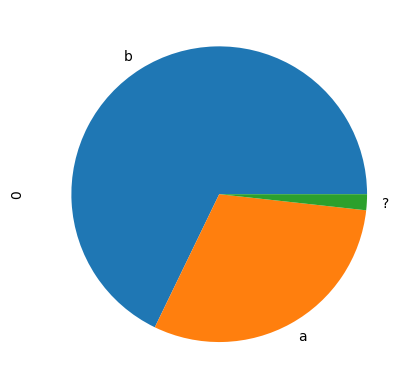

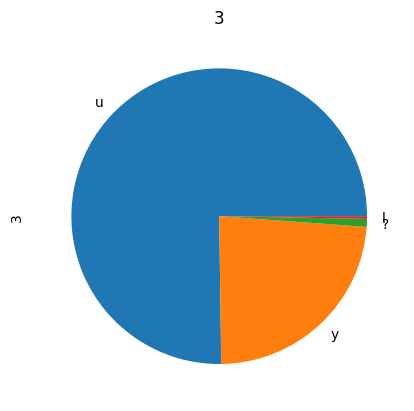

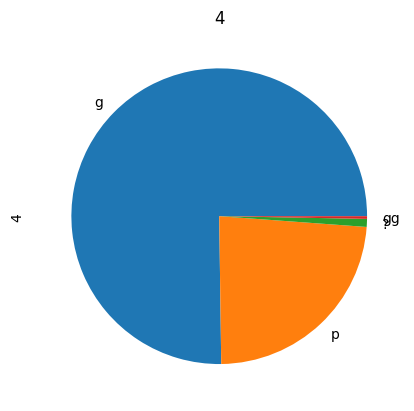

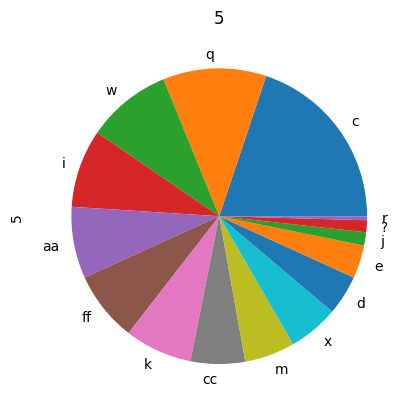

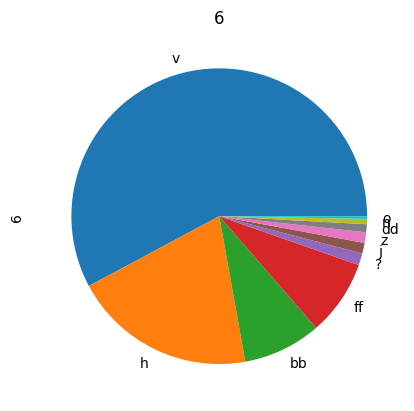

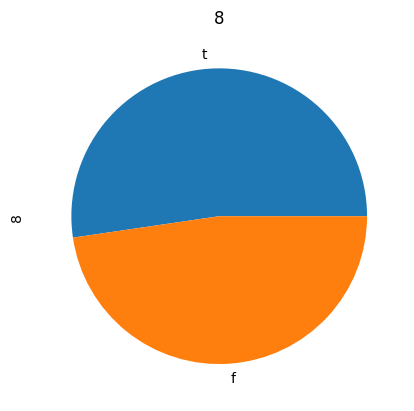

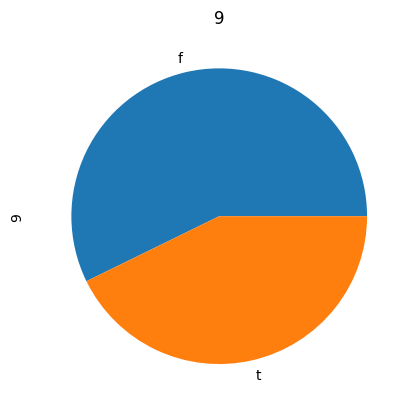

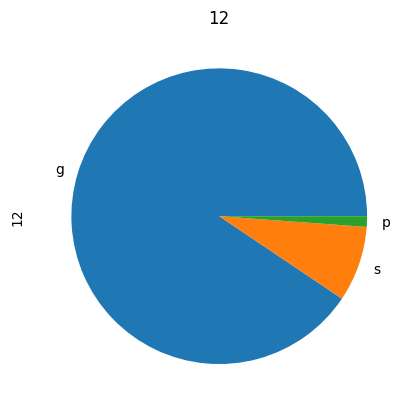

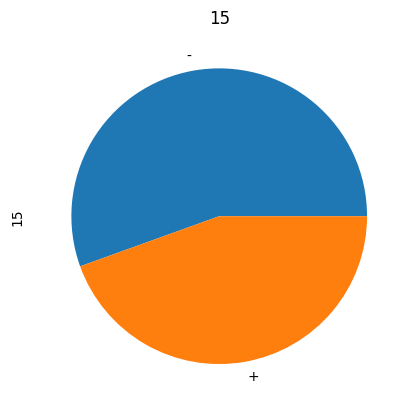

In [22]:
for object in object_list:
    if object not in [1, 13]:
        df[object].value_counts(normalize=True, dropna=False).plot.pie(title=object)
        plt.show()

In [23]:
# Frequency for column 1
print(df[1].value_counts(dropna=False))


?        12
22.67     9
20.42     7
18.83     6
24.50     6
         ..
48.25     1
28.33     1
18.75     1
18.50     1
36.42     1
Name: 1, Length: 350, dtype: int64


# Splitting the datset into train and test sets

In [24]:

# Split into training and test sets
cc_apps_train, cc_apps_test = train_test_split(df, test_size=0.33, random_state=42)

# Handing the missing values

In [25]:
# Count how many columns have "?" as a value
has_question_mark = []
for column in df.columns:
    # Convert column to string to ensure .str accessor works
    cnt_question_mark = sum(df[column].astype(str).str.contains('\?', regex=True).fillna(0).astype(int))
    print(f"Column {column} has {cnt_question_mark} ?")
    if cnt_question_mark > 0 :
        has_question_mark.append(column)

print(f'These columns have question marks {has_question_mark}')

Column 0 has 12 ?
Column 1 has 12 ?
Column 2 has 0 ?
Column 3 has 6 ?
Column 4 has 6 ?
Column 5 has 9 ?
Column 6 has 9 ?
Column 7 has 0 ?
Column 8 has 0 ?
Column 9 has 0 ?
Column 10 has 0 ?
Column 12 has 0 ?
Column 14 has 0 ?
Column 15 has 0 ?
These columns have question marks [0, 1, 3, 4, 5, 6]


In [26]:
# Replace question marks with NaN
cc_apps_train_nans_replaced = cc_apps_train.replace("?", np.NaN)
cc_apps_test_nans_replaced = cc_apps_test.replace("?", np.NaN)

In [27]:
# Check for missing value
print('Missing Values Check')
print(cc_apps_train_nans_replaced.isna().sum())
print(cc_apps_test_nans_replaced.isna().sum())

Missing Values Check
0     8
1     5
2     0
3     6
4     6
5     7
6     7
7     0
8     0
9     0
10    0
12    0
14    0
15    0
dtype: int64
0     4
1     7
2     0
3     0
4     0
5     2
6     2
7     0
8     0
9     0
10    0
12    0
14    0
15    0
dtype: int64


In [28]:
# Initialize cc_apps_train_imputed and cc_apps_test_imputed with the same structure as cc_apps_train_nans_replaced and cc_apps_test_nans_replaced
cc_apps_train_imputed = cc_apps_train_nans_replaced.copy()
cc_apps_test_imputed = cc_apps_test_nans_replaced.copy()

# Calculate the mean for numeric columns
numeric_columns = cc_apps_train_nans_replaced.columns[(cc_apps_train_nans_replaced.dtypes !='object')]
numeric_means = cc_apps_train_nans_replaced[numeric_columns].mean()

# Calculate the most frequent value (mode) in each column of cc_apps_train_nans_replaced
column_modes = cc_apps_train_nans_replaced.mode().iloc[0]

# Impute Missing values in numeric columns
for column in cc_apps_train_nans_replaced.columns:
    if cc_apps_train_nans_replaced[column].dtype !='object':
        cc_apps_train_imputed[column] = cc_apps_train_nans_replaced[column].fillna(numeric_means[column])
        cc_apps_test_imputed[column] = cc_apps_test_nans_replaced[column].fillna(numeric_means[column])
    else:
        cc_apps_train_imputed[column] = cc_apps_train_nans_replaced[column].fillna(column_modes[column])
        cc_apps_test_imputed[column] = cc_apps_test_nans_replaced[column].fillna(column_modes[column])
        
 # Hold this if project does not acccept answer cc_apps_train_nans_replaced[column].value_counts().index[0]

# Preprocessing

In [29]:
# Create music_dummies (one-hot encoding)
cc_apps_train_cat_encoding = pd.get_dummies(cc_apps_train_imputed, drop_first=True)
cc_apps_test_cat_encoding = pd.get_dummies(cc_apps_test_imputed, drop_first=True)

# Reindex so that test has the same columns as train
cc_apps_test_cat_encoding = cc_apps_test_cat_encoding.reindex(columns=cc_apps_train_cat_encoding.columns, fill_value=0)

# Segregating features and labels and feature rescaling

In [30]:
# Split features X and labels y
X_train, y_train = cc_apps_train_cat_encoding.iloc[:, :-1] , cc_apps_train_cat_encoding.iloc[:, [-1]]

X_test, y_test = cc_apps_test_cat_encoding.iloc[:, :-1] , cc_apps_test_cat_encoding.iloc[:, [-1]]

In [31]:
from sklearn.preprocessing import MinMaxScaler

# Assuming X_train and X_test are pandas DataFrames
# Convert column names to string to avoid the error
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Instantiate MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Fit on training data
rescaledX_train = scaler.fit_transform(X_train)

# Transform on test data
rescaledX_test = scaler.transform(X_test)

# Training and evaluating a logisitic regression

In [32]:
# Instantiate 
logreg = LogisticRegression()

# Train
logreg.fit(rescaledX_train, y_train)

# Predict
y_pred = logreg.predict(rescaledX_test)

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))


[[ 93  10]
 [ 25 100]]


# Hyperparameter search and tuning

In [33]:
# Parameters
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]

# Create a dictionary where tol and max_iter are keys and the lists of their values are the corresponding values
param_grid = dict(tol=tol, max_iter=max_iter)

# Instantiate grid_dt
grid_model = GridSearchCV(estimator=logreg,
                       param_grid=param_grid,
                       cv=5)

# Fit
grid_model_result = grid_model.fit(rescaledX_train, y_train)

# Extract best model
best_model =grid_model_result.best_estimator_
best_params = grid_model_result.best_params_
best_score = grid_model_result.best_score_

# Evalute
y_pred = best_model.predict(rescaledX_test)

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

print(
    "Accuracy of logistic regression classifier: ",
    best_model.score(rescaledX_test, y_test),
)


[[ 93  10]
 [ 25 100]]
Accuracy of logistic regression classifier:  0.8464912280701754


In [34]:
print(best_params)
print(best_score)

{'max_iter': 100, 'tol': 0.01}
0.8700561009817672
